#### Introduction
This notebook demonstrates the use of occlusion sensitivity to interpret deep learning models. 

Occlusion sensitivity is a technique that systematically blocks (occludes) parts of an input image and measures how the model's prediction changes. Areas that cause large drops in prediction confidence when occluded are considered highly important for the model's decision.



#### Importing Required Libraries
We begin by importing the necessary libraries, including numpy, matplotlib, and PIL for image processing, as well as Keras for working with deep learning models. Additionally, we import our custom occlusion sensitivity  and visualization modules.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import keras
from keras.applications.imagenet_utils import decode_predictions

sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from interpretabilityLibrary.methods.occlusionSensitivity import OcclusionSensitivity
from interpretabilityLibrary.plot.vizualize import vizualize

os.environ["KERAS_BACKEND"] = "jax"

2025-04-01 15:23:55.985667: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 15:23:56.055119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743521036.143131   14262 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743521036.166505   14262 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 15:23:56.227027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Bellow, we load the pre-trained MobileNetV2 model with weights from ImageNet.

In [2]:
model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=True,
    weights='imagenet'
)

2025-04-01 15:24:15.884097: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Next, we download an example image of an elephant, preprocess it to match the input requirements of the model, and display it. The image is resized to 224x224 pixels, converted to a NumPy array, normalized to the range [-1, 1], and expanded to include a batch dimension.

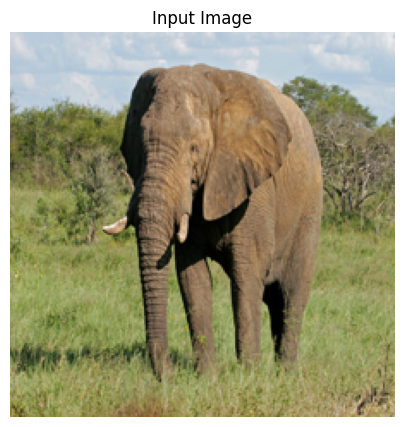

In [3]:
from urllib.request import urlretrieve
from PIL import Image

img_url = "https://storage.googleapis.com/tensorflow/keras-applications/tests/elephant.jpg"
urlretrieve(img_url, "test_image.jpg")

# Load and resize to smaller dimensions
img_size = (224, 224)
img = Image.open("test_image.jpg").convert('RGB')
img = img.resize(img_size)
img_array = np.array(img)

# Display the input image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')
plt.show()

# convert to float32 
x = img_array.astype(np.float32)
# model expects [-1, 1] range
x = x / 127.5 - 1.0  
x = np.expand_dims(x, axis=0)  # Add batch dimension

In this cell, we use the model to predict the class of the input image and display the top 3 predictions along with their confidence scores. We then create an OcclusionSensitivity explainer to analyze which parts of the image contribute most to the model's prediction for the top class. Finally, we visualize the occlusion sensitivity results and save the visualization as an image file.

Getting model prediction...


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Top 3 predictions:
1. African_elephant (0.7223)
2. tusker (0.1593)
3. Indian_elephant (0.0131)
Creating explainer...


I0000 00:00:1743521067.002699   14262 service.cc:148] XLA service 0x5599b4d0a610 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743521067.002730   14262 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1743521067.060903   14262 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Visualizing results...
Plot saved to occlusion_demo.png


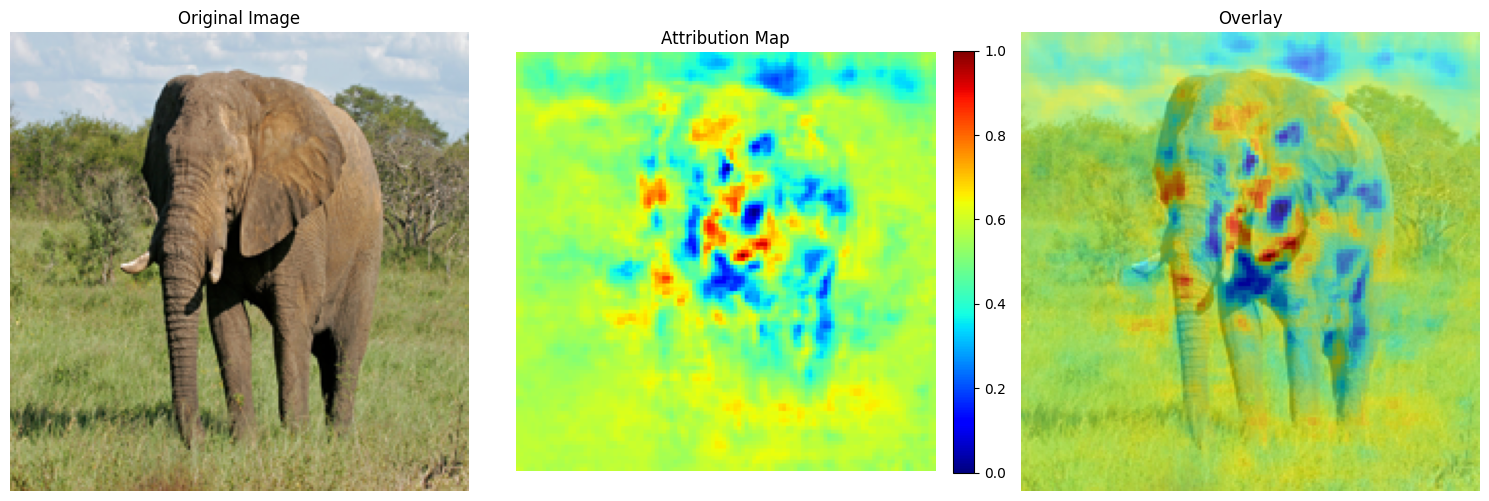

In [4]:
print("Getting model prediction...")
preds = model.predict(x)
top_indices = np.argsort(preds[0])[-3:][::-1]
top_confidences = preds[0][top_indices]
class_names = decode_predictions(preds, top=3)[0]
target_class = top_indices[0]

print("\nTop 3 predictions:")
for i, (_, name, conf) in enumerate(class_names):
    print(f"{i+1}. {name} ({top_confidences[i]:.4f})")


print("Creating explainer...")
explainer = OcclusionSensitivity(model)
explanation = explainer.explain(x, targets=target_class)

print("Visualizing results...")
vizualize(explanation, img_array, save_path="occlusion_demo.png")

In this step, we generated an occlusion sensitivity analysis visualization. The results include three panels: the original image, the attribution map, and an overlay of the attribution map on the original image. The attribution map highlights the regions of the image that contributed most to the model's prediction.

Interestingly, the explainer used not only the elephant itself but also parts of the surrounding environment to make its decision. The reddest areas in the attribution map, which indicate the highest importance, are concentrated around the edges of the elephant's ears. This suggests that the model heavily relied on these features to classify the image.

Let's generate explanations for the other two highly probable classes: tusker and Indian elephant

In [ ]:
# Second prediction (2nd)
# tusker
second_class_idx = top_indices[1]
second_class_name = class_names[1][1]
second_confidence = top_confidences[1]
print(f"Explaining second prediction: {second_class_name}...")
explanation_second = explainer.explain(x, targets=second_class_idx)

# Third prediction (3rd)
# Indian elephant
third_class_idx = top_indices[2]
third_class_name = class_names[2][1]
third_confidence = top_confidences[2]
print(f"Explaining third prediction: {third_class_name}...")
explanation_third = explainer.explain(x, targets=third_class_idx)


Explaining second prediction: tusker...


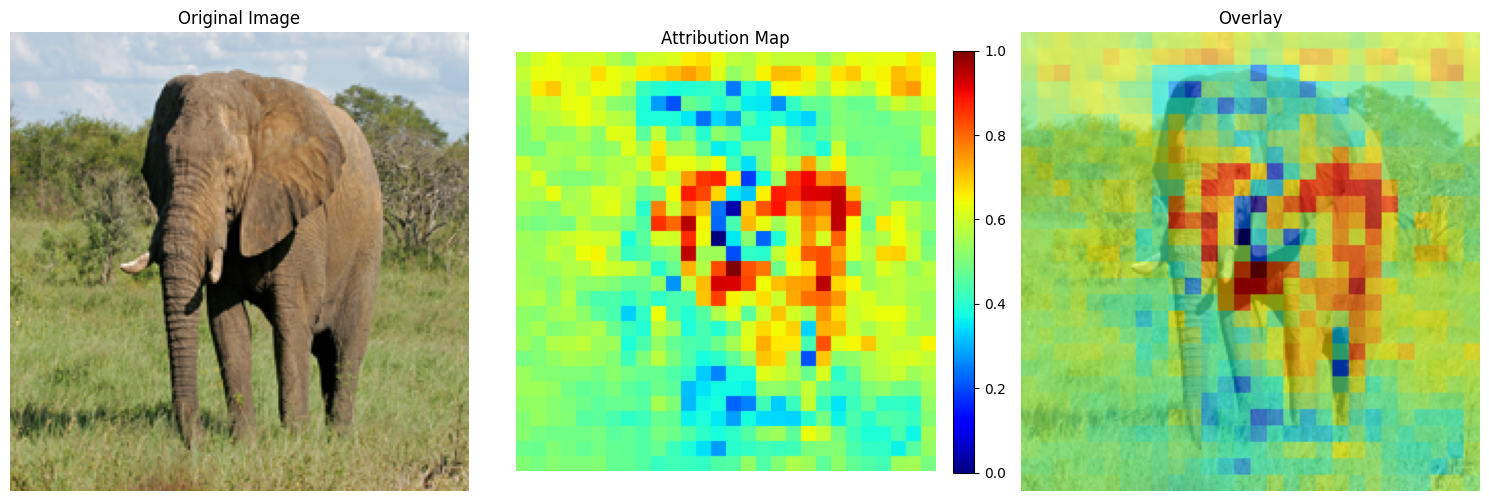

In [ ]:
vizualize(explanation_second, img_array)

The visualization above represents the occlusion sensitivity analysis for the model's prediction of the class 'tusker.' It highlights features that both 'tusker' and 'African elephant' share, particularly the ears, trunk, and certain body regions. These emphasized areas reveal why the model considered 'tusker' as a potential classification for this African elephant image, showing which common characteristics between the two classes led to this secondary prediction.

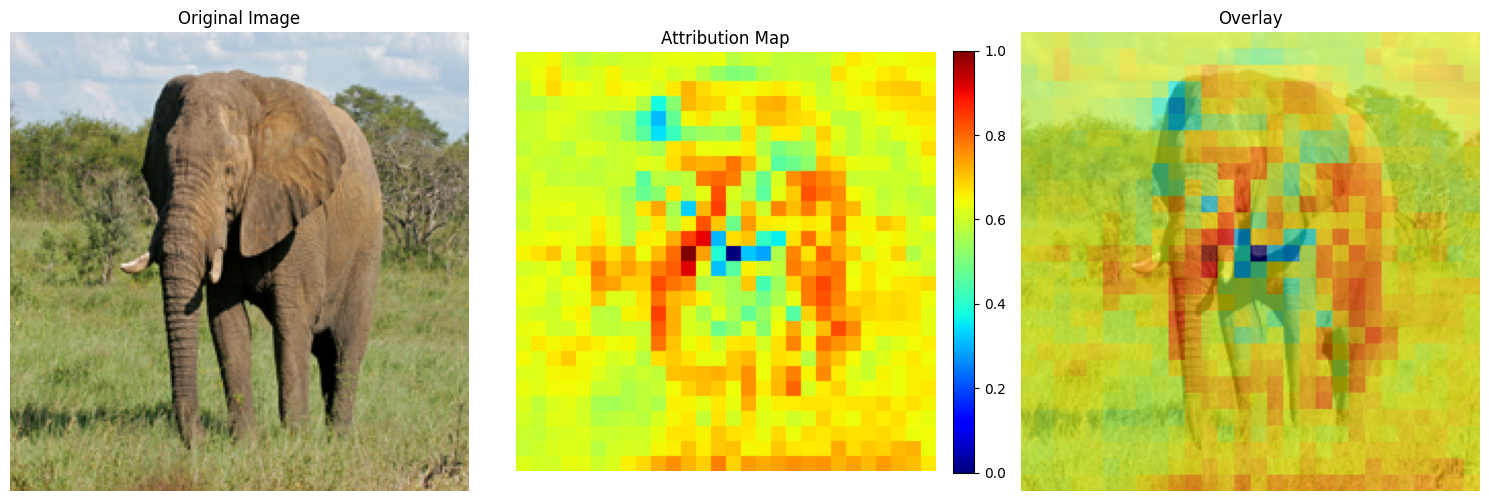

In [ ]:
vizualize(explanation_third, img_array)

The occlusion map above reveals why the model gave 'Indian elephant' some consideration. It shows that the model focuses on features like the trunk and certain body parts that are common to both African and Indian elephants. Interestingly, the tips of the ears are marked in blue, indicating lower importance to this classification of Indian elephant. This makes sense because Indian elephants typically have smaller, rounder ears compared to African elephants' larger, more fan-like ears.